# MNIST Classification with Multilayer Perceptron Network

In [1]:
#Importing the libraires that are going to be used
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
from tensorflow.keras import datasets, layers, Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt
import numpy as np

In [2]:
# check the  version of tensorflow
print("Tensorflow version: {}\n".format(tf.__version__))
# Check if GPU is available
tf.config.list_physical_devices('GPU')

Tensorflow version: 2.10.0



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Prepare the MNIST Data

In [3]:
# Get the MNIST dataset
import numpy as np
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Change the range of values from 0-255 to 0-1
X_train,  X_test = X_train/255.0, X_test/255.0

# Add a dimension to the datasets for the image channel management of tensorflow
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [4]:
X_train.shape

(60000, 28, 28, 1)

Now let's visualize the data which we are working with

The sample image is:



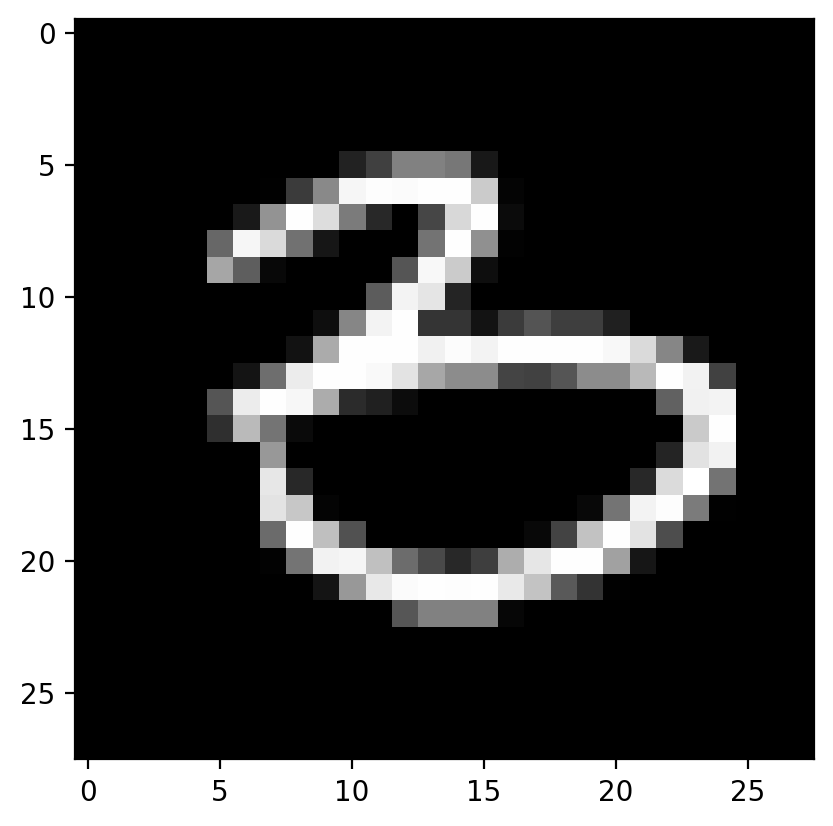

The label is:  [3]


In [5]:
# let's take a sample of the X_train data and render it with plt
print("The sample image is:\n")
img = np.random.randint(X_train.shape[0], size=1)
# print(X_train[img].squeeze().shape)
plt.imshow(X_train[img].squeeze(), cmap='gray')
plt.show()
print("The label is: ", y_train[img])

In [6]:
def display_images_from_data(train_data, test_data, rows = 3, cols = 4, figsize_x = 15, figsize_y = 10):
    rand_data_vector = np.random.randint(0, len(train_data), rows * cols)
    subplot_counter = 1
    plt.figure(figsize=(figsize_x, figsize_y))
    plt.suptitle('Images from train data', fontsize=20)
    for row in range(rows):
        for col in range(cols):
            plt.subplot(rows, cols, subplot_counter)
            plt.imshow(train_data[rand_data_vector[row+col]].squeeze(), cmap='gray')
            plt.title('Label: ' + str(test_data[rand_data_vector[row+col]]))
            plt.axis('off')
            subplot_counter += 1
    plt.show()

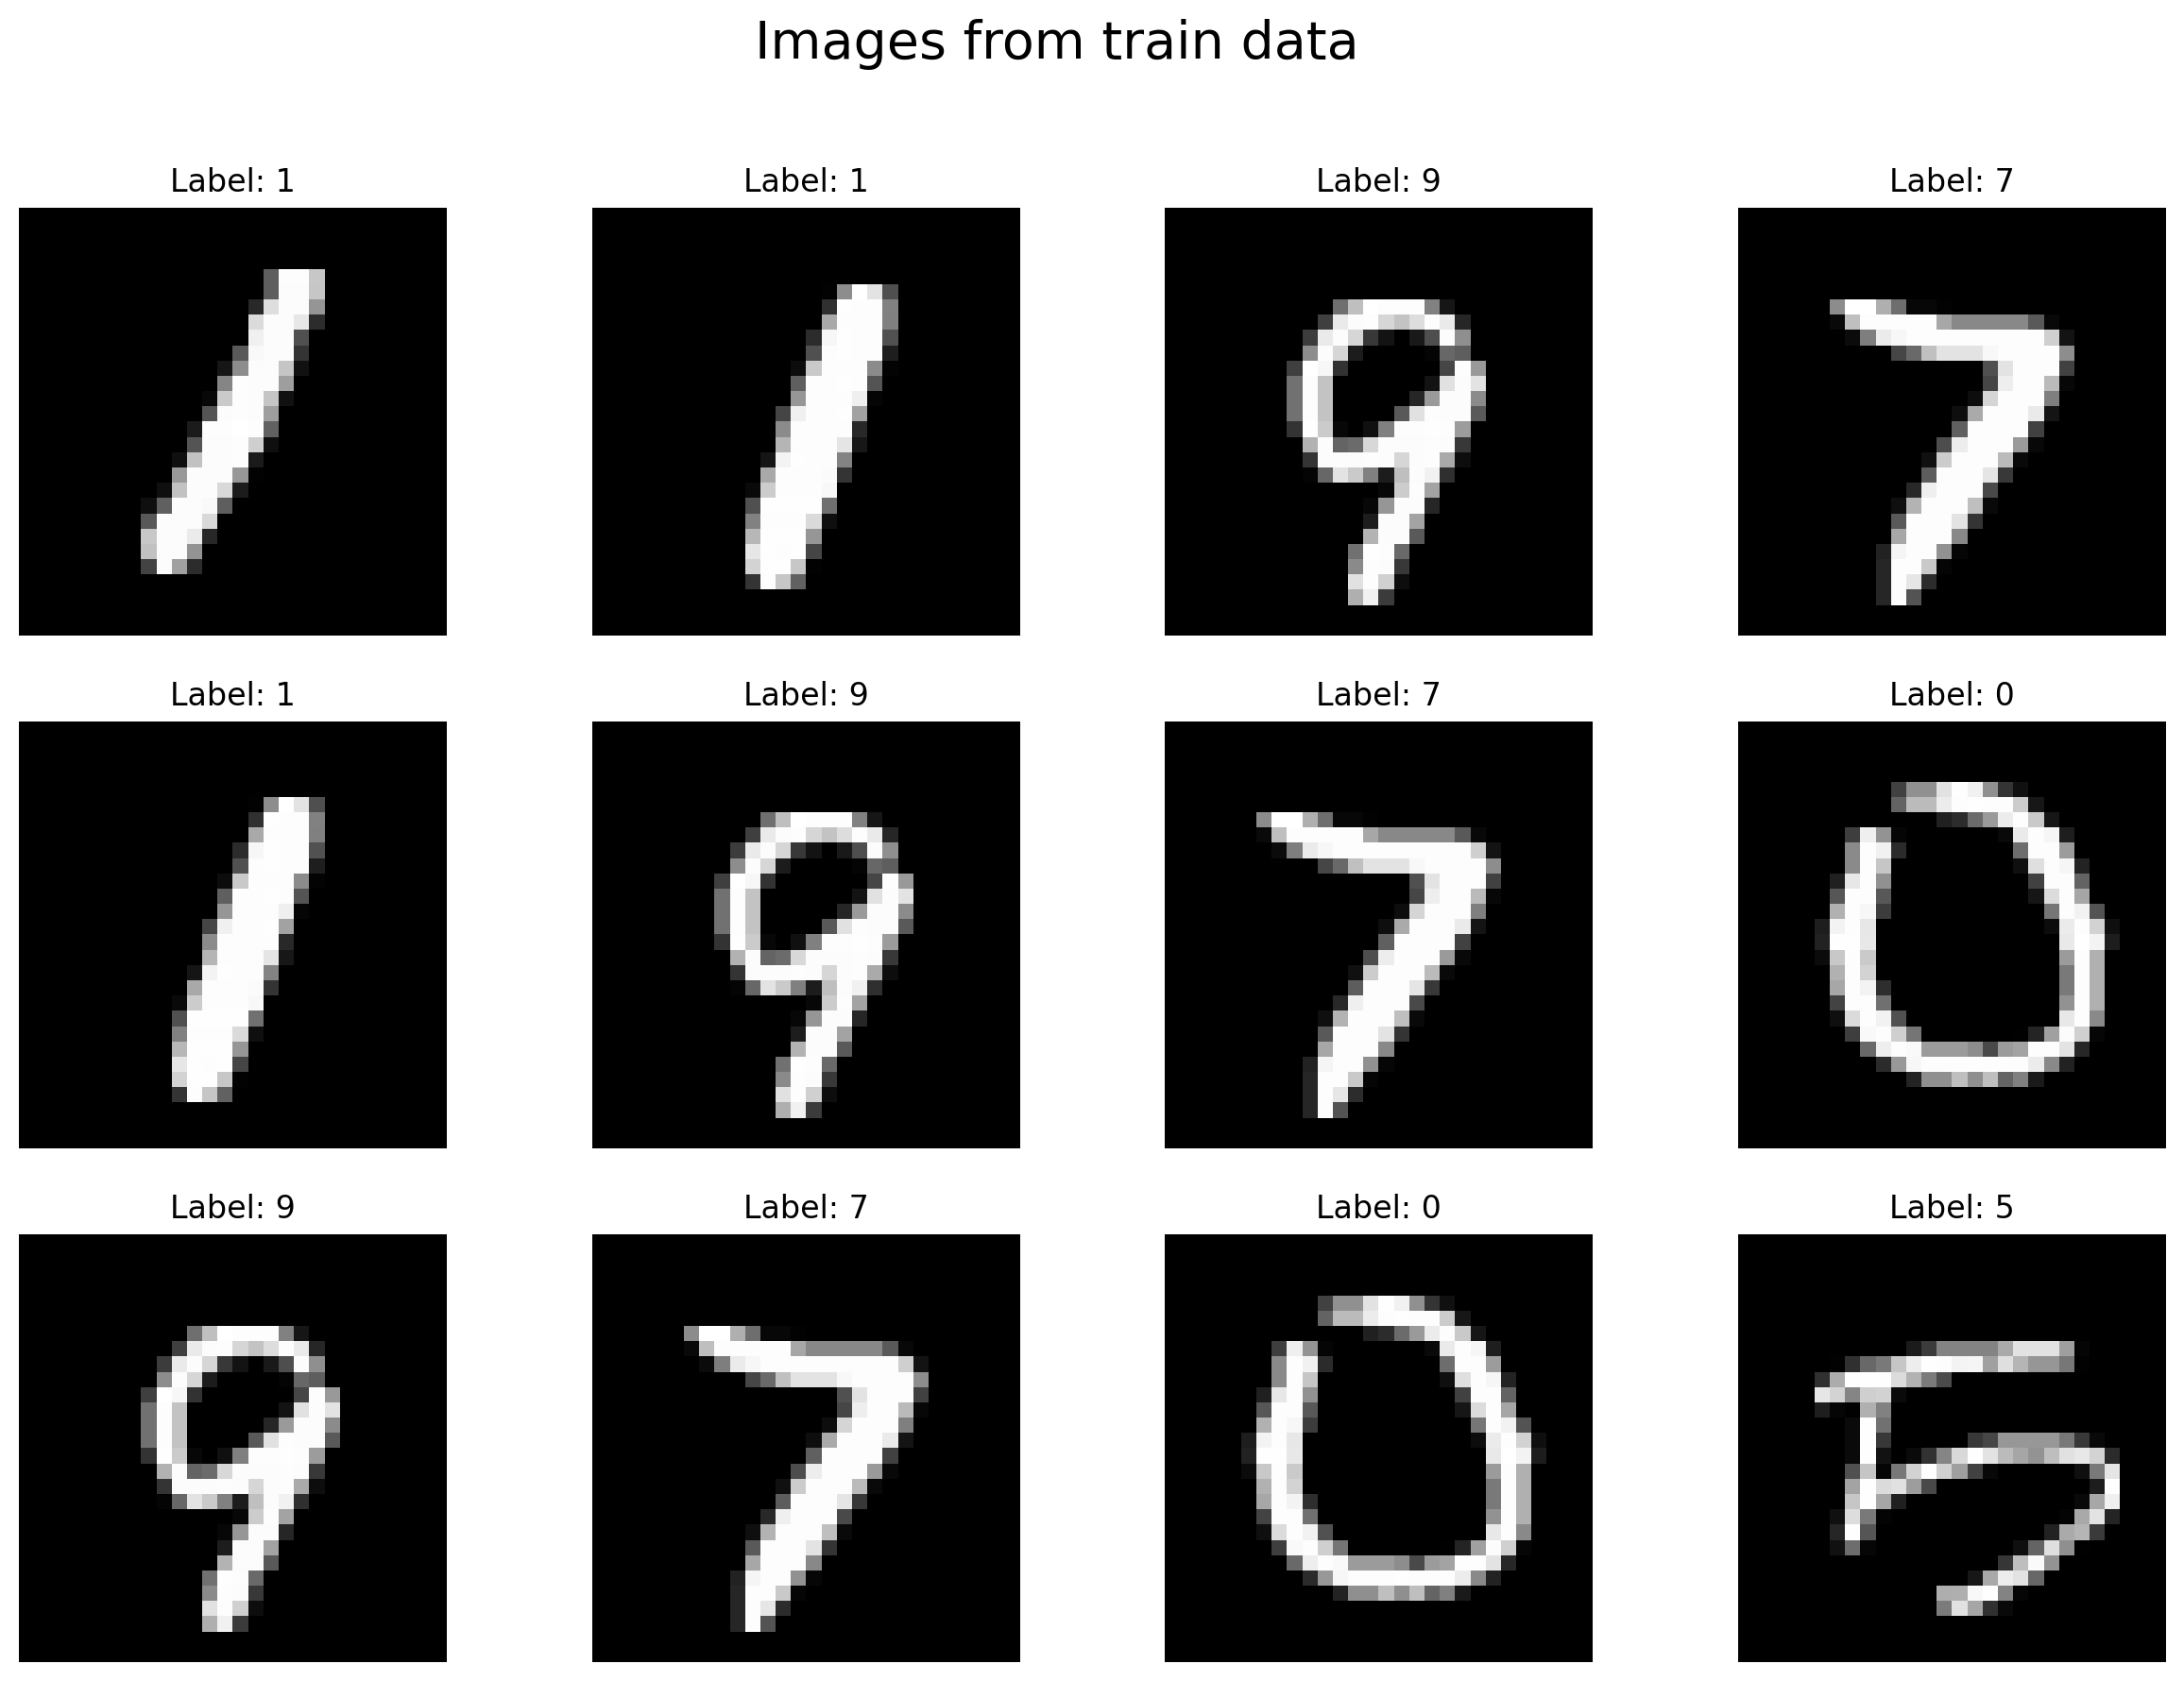

In [7]:
display_images_from_data(X_train, y_train)

### Definition of the hyperparameter that we are to use to train the model

In [8]:
# Defintion of the hyperparameters
input_size = 784
hidden_size = [256, 128, 64]
output_size = 10
num_epochs = 6
batch_size = 64

### Batch and shuffle the datasets

In [9]:
# Built the input pipeline with the use of tf.data
dataset = tf.data.Dataset.from_tensor_slices

train_ds = dataset((X_train, y_train)).shuffle(1000).batch(batch_size)
test_ds = dataset((X_test, y_test)).shuffle(1000).batch(batch_size)

In [10]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

## Definition of the model

### Functional API

In [11]:
# Defintion of the Net model Using the functional API of tensorflow
class Net(Model):
    def __init__(self, input_size=784, output_size=10, activation='relu', hidden_size = [128]):
        super(Net, self).__init__()
        #Flaten the input data
        self.flatten = layers.Flatten()
        #First fully connected layer
        self.input_layer = layers.Dense(input_size, activation=activation)
        #Hidden layers definition
        self.hidden_layers = []
        for n in hidden_size:
            self.hidden_layers.append(layers.Dense(n, activation=activation))
        self.output_layer = layers.Dense(output_size, activation='softmax')

    def call(self, x):
        x = self.flatten(x)
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

### Definition of the Model, lost function and optimizer

In [12]:
model = Net(input_size=input_size, output_size=output_size, hidden_size=hidden_size)
loss_function = SparseCategoricalCrossentropy()
optimizer = Adam()

### Definition of the evaluation metrics

In [13]:
# Computes the (weighted) mean of the given values.
loss_metric     = Mean
# Calculates how often predictions match integer labels.
accuracy_metric = SparseCategoricalAccuracy

# These metrics accumulate the values over time.
train_loss = loss_metric(name='train_loss')
train_accuracy = accuracy_metric(name='train_accuracy')
test_loss = loss_metric(name='test_loss')
test_accuracy = accuracy_metric(name='test_accuracy')

## Definition of the training loop

In [14]:
# Compiles a function into a callable TensorFlow graph.
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_function(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [15]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_function(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [22]:
def fit(train_dataset, test_dataset, epochs):
    for epoch in range(epochs):
        for images, labels in train_dataset:
            train_step(images, labels)
        
        for images, labels in test_dataset:
            test_step(images, labels)
        
        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy {4:.4f}'
        print(template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result(),
                              test_loss.result(),
                              test_accuracy.result()))
        
        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

In [23]:
np.set_printoptions(precision=3)
fit(train_ds, test_ds, epochs=num_epochs)

Epoch 1, Loss: 0.0235, Accuracy: 0.9926, Test Loss: 0.0999, Test Accuracy 0.9775
Epoch 2, Loss: 0.0179, Accuracy: 0.9944, Test Loss: 0.0848, Test Accuracy 0.9811
Epoch 3, Loss: 0.0173, Accuracy: 0.9944, Test Loss: 0.0942, Test Accuracy 0.9809
Epoch 4, Loss: 0.0164, Accuracy: 0.9952, Test Loss: 0.0987, Test Accuracy 0.9798
Epoch 5, Loss: 0.0157, Accuracy: 0.9953, Test Loss: 0.0943, Test Accuracy 0.9799
Epoch 6, Loss: 0.0118, Accuracy: 0.9966, Test Loss: 0.0862, Test Accuracy 0.9817
